<a href="https://colab.research.google.com/github/ESandML/ANN-Demo/blob/main/ANN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Artificial Neural Network Function Approximation Demonstration

This notebook is provided as a learning resource to aid students of machine learning in understanding artificial neural networks (ANNs).

With this resource, you are able to visualise an animation of the function approximated by an ANN as the network is trained on synthetic data with a known underlying function, as well as a decomposition of the final approximation. In this, you can experiment with different data and hyperparameters, such as the number of hidden layers, the number of hidden neurons, and the activation function, allowing for interactive learning. The visualisations are based on real Python code for training neural networks that is built in PyTorch, a popular library for deep learning, providing an accessible insight into the tools used to build today's advanced artificial intelligence systems.

For guidance through this notebook, please see: youtube.link



## Definition of ANNs considered by this notebook

For simplicity, the notebook focuses on shallow neural networks and multilayer perceptrons (MLPs), and the trivial problem of regression with 1D inputs and outputs. However, the principles demonstrated apply to more complicated networks and problems.

As shown below, the key difference between these architectures is whether there is one, or multiple, hidden layers.

<p align="center">
	<img height=400, src="https://drive.google.com/uc?export=view&id=1_JVhoR7sbGxKQW9vGRiIBc2LtNL2GgUM"> <br />
	<em>
		Shallow neural network for regression with 1D inputs and outputs.
	</em>
</p>

<p align="center">
	<img height=400, src="https://drive.google.com/uc?export=view&id=1PBVZ0Wkk48eqMHhtm4DkEWCpET4EhOYz"> <br />
	<em>
		MLP for regression with 1D inputs and outputs.
	</em>
</p>

In both cases, the output of the input layer is just the input $a_{0,1}=x$. Then, at the $j^{th}$ neuron in the $i^{th}$ hidden layer, where $j\in\{1,2,\ldots,N_i\}$ and $i\in \{1,2,\ldots,H\}$ ($H=1$ for shallow neural networks), we perform the following operation:

\begin{equation}
a_{i,j}=\mathrm{activation}\left(s_{i,j}\right)
\end{equation}

where $\mathrm{activation}$ is the chosen activation function and:

\begin{equation}
s_{i,j}=b_{i,j}+\sum_{k=1}^{N_{i-1}}w_{i,j,k}a_{i-1,k}
\end{equation}

where $b_{i,j}$ is the bias of the neuron, $N_{i-1}$ is the number of neurons in the previous layer, $w_{i,j,k}$ is the neuron's weight for the $k^{th}$ neuron in the previous layer, and $a_{i-1,k}$ is the output of the $k^{th}$ neuron in the previous layer. The result is $a_{i,j}$, which is the output of the neuron.

The output of the network is then:

\begin{equation}
\hat{y}=a_{H+1,1}=b_{H+1,1}+\sum_{k=1}^{N_{H}}w_{H+1,1,k}a_{H,k}
\end{equation}

An important principle to realise is that we can frame an MLP as a composition of shallow neural networks. By understanding how a shallow neural network processes information, we can therefore think of an MLP as performing repetitions of this.

Given a dataset $D=\{\left(x_i,y_i\right)\}_{i=1}^M$ of $M$ examples of $(x,y)$ pairs, assuming that the $(x,y)$ pairs follow some underlying function $f(x)=y+\varepsilon$, where $\varepsilon\sim p_\varepsilon$ denotes some noise, the network can be trained to approximate $f(x)$. This training requires the specification of some loss function, which is the measure of predictive error that the training process will aim to minimise, as well as an optimiser, which will adjust the parameters (weights and biases) at each iteration on some basis such as to reduce the loss on the next iteration. For simplicity, this notebook uses the mean squared error (MSE) loss function, a popular loss function for regression tasks, and gradient descent.

Note that gradient descent is implemented here using the stochastic gradient descent (SGD) optimiser in PyTorch (`torch.optim.SGD`). However, by using the entire dataset in each iteration, as we do here, this becomes gradient descent rather than SGD.

## Import modules

The first thing we need to do is to import the modules that are used by the code.

In [ ]:
#@title Import modules
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

## Define function to be learned

Next, we will define an arbitrary function that will govern the data that we will train the model on. This definition will include an equation for the function and the interval (set of $x$ values) over which the function will be considered. Expand to uncomment or define the equation/interval you want to consider, ensuring all other options are commented out.

In [ ]:
#@title Define equation of function
def target_fn(x):
  # return x**2
  # return torch.sin(x)
  # return 0.1 * x**3 + 0.1 * x**2 - 0.5 * x
  # return 0.05 * x**4 + 0.2 * x**3 - 0.1 * x**2 - 0.4 * x
  return 0.00002*x**5 + 0.0005 * x**4 + 0.002 * x**3 - 0.001 * x**2 - 0.004 * x

In [ ]:
#@title Set function interval
# supp_x = [-torch.pi, torch.pi]
# supp_x = [-4, 3]
supp_x = [-20, 7]

## Visualise defined function.

Expand and run the contained cell to visualise the defined function.

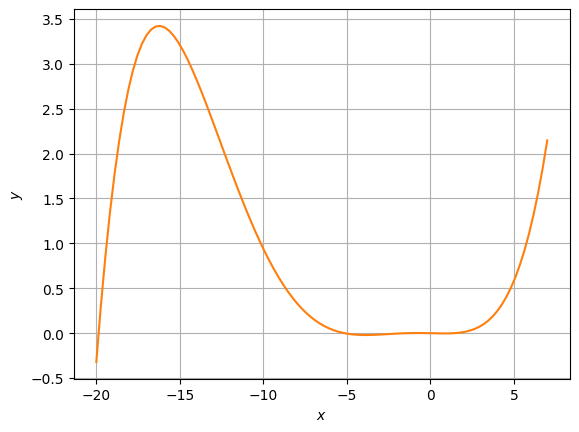

In [ ]:
#@title Compute and visualise target function
#Compute target function
x_ = torch.linspace(supp_x[0], supp_x[1], 100)
range_x = supp_x[1] - supp_x[0]
mid_x  =sum(supp_x) / 2
tf_x = target_fn(x_)
supp_y = [tf_x.min(), tf_x.max()]
range_y = supp_y[1] - supp_y[0]
mid_y = sum(supp_y) / 2

#Visualise target function
plt.plot(x_, tf_x, 'C1')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

## Generate dataset

With the underlying function defined, we can generate the dataset. Expand to modify the number of samples, the standard deviation of the noise, and the random seed. For simplicity, we will consider Gaussian noise.

In [ ]:
#@title Define number of samples, standard deviation of noise, and random seed
n_samples = 300               #Number of samples in dataset

noise_scale = 0.2              #Standard deviation of noise added to targets

torch.manual_seed(42)         #Random seed

In [ ]:
#@title Generate features and labels
#Generate features
x = torch.rand((n_samples,)) * range_x + supp_x[0]

#Generate labels
y = target_fn(x)+(torch.randn((n_samples,))*noise_scale)

normalised = False

## Visualise dataset

Expand and run the contained cell to visualise the generated dataset.

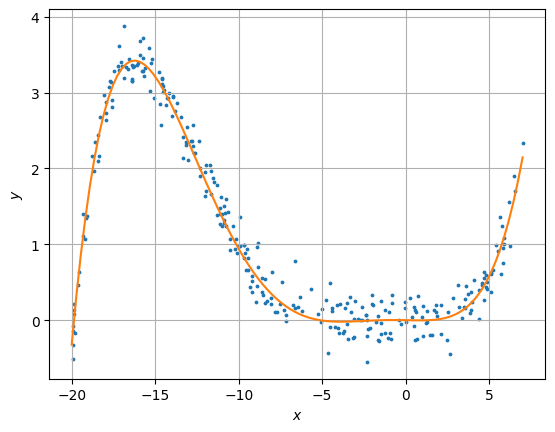

In [ ]:
#@title Visualise data with function
plt.plot(x_,tf_x,'C1')
plt.scatter(x,y,s=3, color='C0')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

## Split the dataset

For the purpose of detecting overfitting on the training data, it is common practice to leave out some of the dataset for validation. This allows us check the performance of the model on some data it has not been trained on, during training. Here, we use 70:30 random split.

In [ ]:
#@title Shuffle and split data and send to device
shuff_idx=torch.randperm(x.size(0))
train_size=np.floor(0.7*x.size(0)).astype('int')
device='cuda' if torch.cuda.is_available() else 'cpu'
xtrain=x[shuff_idx[:train_size]].unsqueeze(1).to(device)
xtest=x[shuff_idx[train_size:]].unsqueeze(1).to(device)
ytrain=y[shuff_idx[:train_size]].unsqueeze(1).to(device)
ytest=y[shuff_idx[train_size:]].unsqueeze(1).to(device)

## Visualise training and validation subsets

Expand and run the contained cells to visualise the training data and the validation data following the split.

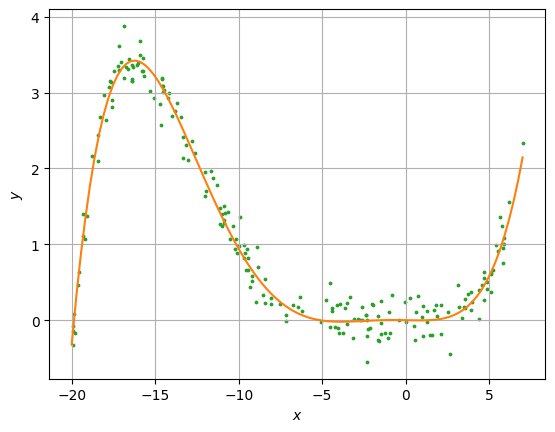

In [ ]:
#@title Visualise training data
plt.scatter(xtrain.cpu(),ytrain.cpu(),s=3,color='C2')
plt.plot(x_,target_fn(x_),'C1')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

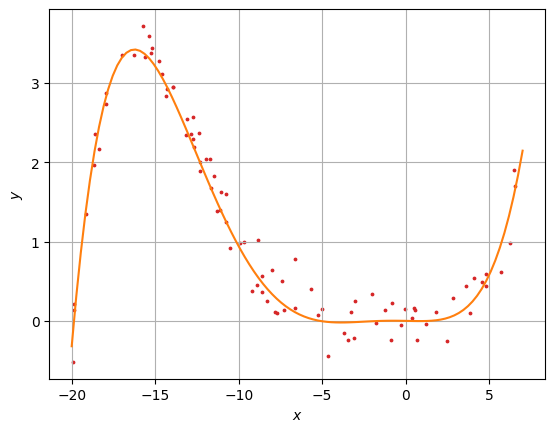

In [ ]:
#@title Visualise validation data
plt.scatter(xtest.cpu(),ytest.cpu(),s=3,color='C3')
plt.plot(x_,target_fn(x_),'C1')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

## Define hyperparameters of network

Expand to modify the hyperparameters of the network.

`norm` will shift and scale the data (both $x$ and $y$ values) to 0 mean and unit variance, which can provide better a better basis for gradient-based optimisation. For example, `norm = True` will perform this operation, whereas `norm = False` will leave the data unchanged.

`n_neurons` will specify the number of hidden neurons in each layer. For example, `n_neurons = [4,]` will create a shallow network with a single hidden layer with 4 neurons, while `n_neurons = [16,8,4]` will create an MLP with 3 hidden layers with 16 neurons in the first, 8 neurons in the second, and 4 neurons in the third. Please note that the visualisation of the decomposition of the approximation, covered later on in this notebook, will only work for shallow neural networks.

`activation` will specify the activation function used in the hidden layers. For example, `activation = torch.nn.ReLU()` will cause the model to use the rectified linear unit (ReLU). For experimenting with no activation, use `activation = torch.nn.Identity()`.

`opt_kwargs` will specify the parameters of the gradient descent optimiser. `'lr'` is the learning rate, which must be set, while `'momentum'` is an optional parameter that incorporates momentum. For example, `opt_kwargs = {'lr':0.01}` will lead to gradient descent with a learning rate of 0.01, whereas `opt_kwargs = {'lr':0.001, 'momentum':0.1}` will lead to gradient descent with a learning rate of 0.001 and momentum with a magnitude of 0.1.

We also set the random seed again such that, whenever the model is built after running this cell, it will be initialised with the same initial parameters.

In [ ]:
#@title Hyperparameters to experiment with
norm=True                     #Whether to normalise the data

n_neurons = [6,]             #Number of neurons in each hidden layer

activation = torch.nn.LeakyReLU()  #Activation function for hidden layers
                              #(see https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity for options)

opt_kwargs = {                #Optimiser parameters
    'lr': 0.01,
    # 'momentum': 0.1
    }

torch.manual_seed(42)         #Set random seed

## Initialise

We will now set the final hyperparameters, build the model and optimiser, normalise data (if `norm = True`), and initialise lists for recording the loss on the training and validation data throughout training.

In [ ]:
#@title Hyperparameters to leave fixed
loss_fn = torch.nn.MSELoss()  #Loss function

optim = torch.optim.SGD       #Optimiser


In [ ]:
#@title Build model
#Build model
n_hidden_layers=len(n_neurons)
parts=[
    torch.nn.Linear(1,n_neurons[0]),
    activation
    ]
for i in range(1,n_hidden_layers):
  parts.append(torch.nn.Linear(n_neurons[i-1],n_neurons[i]))
  parts.append(activation)
parts.append(torch.nn.Linear(n_neurons[-1],1))
model=torch.nn.Sequential(*parts)
model.to(device)
optimizer=optim(model.parameters(), **opt_kwargs)
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
#@title Normalise data, or deactivate normalisation if `norm = False`
#Normalise data
if norm and not normalised:
  xtrain=(xtrain-mid_x)/(range_x/2)
  xtest=(xtest-mid_x)/(range_x/2)
  ytrain=(ytrain-mid_y)/(range_y/2)
  ytest=(ytest-mid_y)/(range_y/2)
  normalised=True
elif not norm: #No rescaling
  mid_x=0
  range_x=2
  mid_y=0
  range_y=2

In [ ]:
#@title Initialise lists for recording train/test loss
#Initialise lists for recording train/test loss
train_plt=[]
test_plt=[]

## Visualise training

We will now train the network. Expand and run the contained cell to visualise an animation of the approximation of the target function throughout training. If the network does not appear to have converged by the end of the training run, run the cell again to continue training.

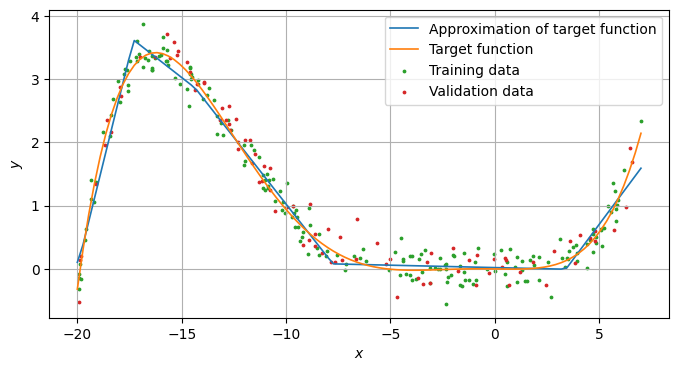

Training run took 113.52 seconds


In [ ]:
#@title Train (run repeatedly until convergence)
%matplotlib inline

def plot(model,x_,mid_x,range_x,mid_y,range_y):
  y_=model(torch.Tensor((x_-mid_x)/(range_x/2)).unsqueeze(1).to(device)).squeeze().detach().cpu()
  clear_output(wait=True)
  fig,ax=plt.subplots(figsize=(8,4),dpi=100)
  plt.plot(x_,mid_y+(range_y/2)*y_,color='C0',linewidth=1.2, label='Approximation of target function')
  plt.plot(x_,tf_x,color='C1',linewidth=1.2, label='Target function')
  plt.scatter(mid_x+(range_x/2)*xtrain.cpu(),mid_y+(range_y/2)*ytrain.cpu(),color='C2',s=3, label = 'Training data')
  plt.scatter(mid_x+(range_x/2)*xtest.cpu(),mid_y+(range_y/2)*ytest.cpu(),color='C3',s=3, label = 'Validation data')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.legend()
  plt.grid()
  plt.show()

t=time.time()
epochs=75000
plot_freq=1000
for epoch in range(epochs):
  model.train()
  optimizer.zero_grad()
  loss=loss_fn(model(xtrain), ytrain)
  loss.backward()
  optimizer.step()
  train_plt.append(loss.item())
  with torch.no_grad():
    model.eval()
    test=loss_fn(model(xtest), ytest).item()
    test_plt.append(test)

    #Plot target function and approximation
    if epoch%plot_freq==0:
      plot(model,x_,mid_x,range_x,mid_y,range_y)
plot(model,x_,mid_x,range_x,mid_y,range_y)
print(f'Training run took {time.time()-t:.2f} seconds')

## Visualise detailed decomposition of approximation of target function (shallow neural networks only)

If a shallow neural network has been used, expand and run the contained cell to visualise a detailed decomposition of the approximation of the target function.

This will create a grid of plots with five columns:

*   The first column will contain a single plot showing the output of the input neuron for varying values of $x$, which is just an identity mapping.
*   The second column will contain $N_1$ plots, one for each hidden neuron, showing the preactivation output which, for the $i^{th}$ hidden neuron, is $w_{1,i} x+b_{1,i}$.
*   The third column will also contain $N_1$ plots, one for each hidden neuron, showing the postactivation output which, for the $i^{th}$ hidden neuron, is $\mathrm{activation}(w_{1,i} x+b_{1,i})$.
*   The fourth column will also contain $N_1$ plots, one for each hidden neuron, showing the multiplication of the postactivation output of the hidden neuron multiplied by the corresponding weight in the output neuron which, for the $i^{th}$ hidden neuron, is $w_{2,i}\mathrm{activation}(w_{1,i} x+b_{1,i})$.
*   The fifth column will contain a single plot showing the output of the output neuron, which is $b_{2,1}+\sum_{i=1}^{N_i}w_{2,i} \mathrm{activation}(w_{1,i} x+b_{1,i})$.



Each plot also shows the target function.

Note that, if `norm = True`, the network will take inputs and predict targets that have been scaled and shifted. All operations are therefore performed in this scaled and shifted space. Hence, to visualise the approximation at each neuron in the original (unscaled/unshifted) space, such as to visualise the approximation of the actual target function, we must reverse the scaling and shifting.

The purpose of visualising this decomposition is to show how a complex function (the output of the network) can be formed from an optimisable weighted sum and translation of simple functions (the outputs of the hidden neurons) of the input. Additionally, we can see how a composition of an optimisable weighted sum and translation with a suitable nonlinear activation function allows for the modelling of these simple functions. In fact, it has been proven that, given enough hidden neurons and enough training data, a shallow neural network can accurately approximate any given function. This is known as the universal approximation theorem ([Hornick *et al.*, 1989](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208)). Note however that the theorem holds true for MLPs and other deep ANNs, which require exponentially fewer neurons than a shallow neural network to reach the same accuracy. As a result, it is usually more effective to increase the number of layers than to increase the number of neurons in a hidden layer.

While it would be possible, we do not visualise the approximation of the target function at this level of detail for MLPs due to the number of plots that would be required. Specifically, if we wished to similarly visualise the weighting of each input to the $i^{th}$ hidden layer, where $i>1$, for each of the $N_i$ neurons in the layer, we would need $N_iN_{i-1}$ plots.


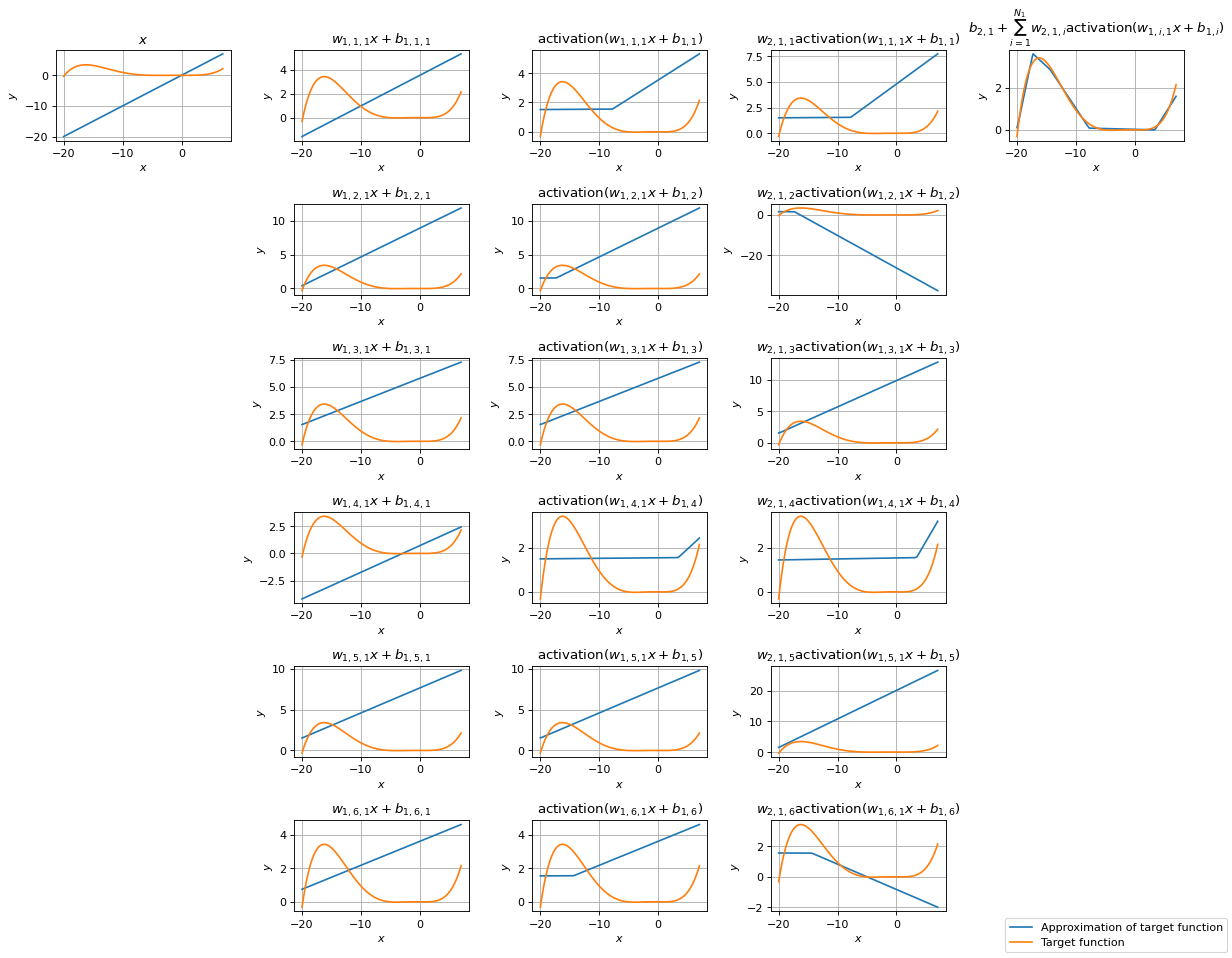

In [ ]:
#@title Visualise detailed decomposition of approximation of target function (shallow neural networks only)
if len(n_neurons)==1:
  rows=n_neurons[0]
  fig, ax = plt.subplots(rows,5,figsize=(15,2*rows),dpi=80)
  ax[0,0].title.set_text('$x$')
  ax[0,0].set_xlabel('$x$')
  ax[0,0].set_ylabel('$y$')
  l1=ax[0,0].plot(x_,x_)[0]
  l2=ax[0,0].plot(x_,tf_x,color='C1')[0]

  ax[0,0].grid()
  a=[]
  for row in range(rows):
    w=model[0].state_dict()['weight'][row].squeeze().detach().cpu()
    b=model[0].state_dict()['bias'][row].squeeze().detach().cpu()
    o=w*(x_-mid_x)/(range_x/2)+b
    ax[row,1].plot(x_,mid_y+(range_y/2)*o)
    ax[row,1].plot(x_,tf_x,color='C1')
    ax[row,1].set_xlabel('$x$')
    ax[row,1].set_ylabel('$y$')
    ax[row,1].title.set_text(f'$w_{{1, {row+1} ,1}} x+b_{{1, {row+1} ,1}}$')
    ax[row,1].grid()
    with torch.no_grad():
      a.append(model[1](o.to(device)).cpu())
    ax[row,2].plot(x_,mid_y+(range_y/2)*a[row])
    ax[row,2].plot(x_,tf_x,color='C1')
    ax[row,2].set_xlabel('$x$')
    ax[row,2].set_ylabel('$y$')
    ax[row,2].title.set_text(f'$\mathrm{{activation}}(w_{{1, {row+1} ,1}} x+b_{{1, {row+1} }})$')
    ax[row,2].grid()

  wa=[]
  for row in range(rows):
    w=model[-1].state_dict()['weight'][0][row].squeeze().detach().cpu()
    wa.append(w*a[row])
    ax[row,-2].plot(x_,mid_y+(range_y/2)*wa[row])
    ax[row,-2].plot(x_,tf_x,color='C1')
    ax[row,-2].set_xlabel('$x$')
    ax[row,-2].set_ylabel('$y$')
    ax[row,-2].title.set_text(f'$w_{{2,1, {row+1} }}\mathrm{{activation}}(w_{{1, {row+1} ,1}} x+b_{{1, {row+1} }})$')
    ax[row,-2].grid()
  b=model[-1].state_dict()['bias'][0].squeeze().detach().cpu()
  ax[0,-1].plot(x_,mid_y+(range_y/2)*(b+torch.stack(wa, dim=0).sum(dim=0)))
  ax[0,-1].plot(x_,tf_x,color='C1')
  ax[0,-1].set_xlabel('$x$')
  ax[0,-1].set_ylabel('$y$')
  ax[0,-1].title.set_text('$b_{2,1}+\sum_{i=1}^{N_1} w_{2,1,i} \mathrm{activation}(w_{1,i,1} x+b_{1,i})$')
  ax[0,-1].grid()
  for i in range(1,rows):
    ax[i,0].remove()
    ax[i,4].remove()
  fig.legend([l1,l2],['Approximation of target function', 'Target function'],loc='lower right')
  fig.tight_layout()
  plt.show()
else:
  print(f'The detailed decomposition visualisation is only implemented for shallow neural networks where len(n_neurons) = 1. Currently, len(n_neurons) = {len(n_neurons)}')

## Visualise less-detailed decomposition of approximation of target function

While it is not practical to visualise the decomposition of the approximation of the target function for MLPs at the same level of detail as this notebook allows for shallow neural networks, it is still useful to visualise a less-detailed decomposition. Expand and run the contained cell to visualise this decomposition.

This will create a grid of plots with $H+2$ columns, one for each layer (including input and output). In the $i^{th}$ column and $j^{th}$ row, where $i\in\{0,1,\ldots,H+1\}$ and $j\in\{1,2,\ldots,N_i\}$, a plot will be shown for the output of $a_{i,j}$ for varying values of $x$.

Considering the detailed decomposition of a shallow neural network that can be produced with the above cell, we can appreciate how the intermediary constituent functions of MLPs, i.e. the operations that allow us to form the output of some neuron $a_{i+2,j}$ from the outputs of neurons $a_{i,1},a_{i,2},\ldots,a_{i,N_i}$, are formed. Thinking of an MLP as performing repetitions of this, while visualising the less-detailed decomposition of the approximation for MLPs, we can appreciate how greater depth allows for a more gradual formation of the approximation. It is on this basis that MLPs can achieve the same performance as shallow neural networks with fewer neurons.

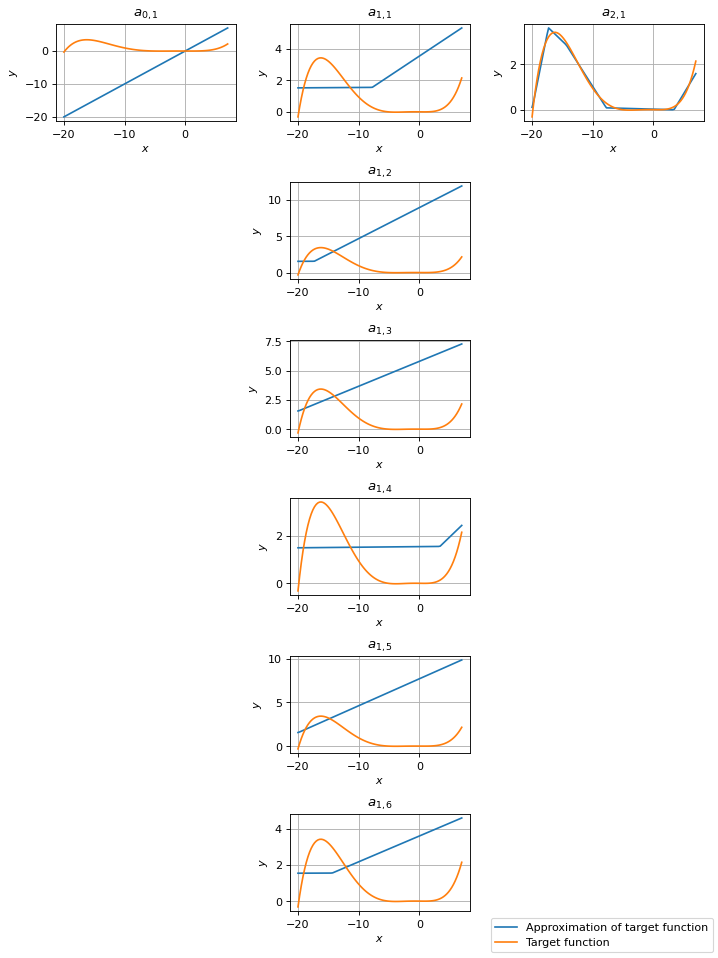

In [ ]:
#@title Visualise less-detailed decomposition of approximation of target function
rows=max(n_neurons)
fig, ax = plt.subplots(rows,2+len(n_neurons),figsize=(3*(2+len(n_neurons)),2*rows),dpi=80)

ax[0,0].title.set_text('$a_{0,1}$')
ax[0,0].set_xlabel('$x$')
ax[0,0].set_ylabel('$y$')
l1=ax[0,0].plot(x_,x_)[0]
l2=ax[0,0].plot(x_,tf_x,color='C1')[0]
ax[0,0].grid()

a=[]
for row in range(n_neurons[0]):
  w=model[0].state_dict()['weight'][row].squeeze().detach().cpu()
  b=model[0].state_dict()['bias'][row].squeeze().detach().cpu()
  o=w*(x_-mid_x)/(range_x/2)+b
  with torch.no_grad():
    a.append(model[1](o.to(device)).cpu())
  ax[row,1].plot(x_,mid_y+(range_y/2)*a[row])
  ax[row,1].plot(x_,tf_x,color='C1')
  ax[row,1].set_xlabel('$x$')
  ax[row,1].set_ylabel('$y$')
  ax[row,1].title.set_text(f'$a_{{1,{row+1}}}$')
  ax[row,1].grid()

for col in range(2,len(n_neurons)+1):
  a_=[]
  for row in range(n_neurons[col-1]):
    wa=[]
    for row_last in range(n_neurons[col-2]):
      w=model[2*col-2].state_dict()['weight'][row][row_last].squeeze().detach().cpu()
      wa.append(w*a[row_last])
    b=model[2*col-2].state_dict()['bias'][row].squeeze().detach().cpu()
    with torch.no_grad():
      a_.append(model[2*col-1](b+torch.stack(wa, dim=0).sum(dim=0).to(device)).cpu())
    ax[row,col].plot(x_,mid_y+(range_y/2)*a_[row])
    ax[row,col].plot(x_,tf_x,color='C1')
    ax[row,col].set_xlabel('$x$')
    ax[row,col].set_ylabel('$y$')
    ax[row,col].title.set_text(f'$a_{{{col},{row+1}}}$')
    ax[row,col].grid()
  a=a_
wa=[]
for row in range(n_neurons[-1]):
  w=model[-1].state_dict()['weight'][0][row].squeeze().detach().cpu()
  wa.append(w*a[row])
b=model[-1].state_dict()['bias'][0].squeeze().detach().cpu()
ax[0,-1].plot(x_,mid_y+(range_y/2)*(b+torch.stack(wa, dim=0).sum(dim=0)))
ax[0,-1].plot(x_,tf_x,color='C1')
ax[0,-1].set_xlabel('$x$')
ax[0,-1].set_ylabel('$y$')
ax[0,-1].title.set_text(f'$a_{{{len(n_neurons)+1},1}}$')
ax[0,-1].grid()
for row in range(1,rows):
  ax[row,0].remove()
  ax[row,-1].remove()
for col in range(1,len(n_neurons)+1):
  if n_neurons[col-1]<rows:
    for row in range(n_neurons[col-1],rows):
      ax[row, col].remove()

fig.legend([l1,l2],['Approximation of target function', 'Target function'],loc='lower right')
fig.tight_layout()
plt.show()

## Out of distribution (OOD) data

An important principle of most current machine learning models is that they can only learn to accurately approximate the underlying function of data over the interval spanned by the training data. This means that data from outside of this interval, known as out of distribution data, will likely not be accurately modelled. To appreciate the implications of this, expand and run the contained cell to visualise the approximation for a wider range of values than the interval spanned by the training data.

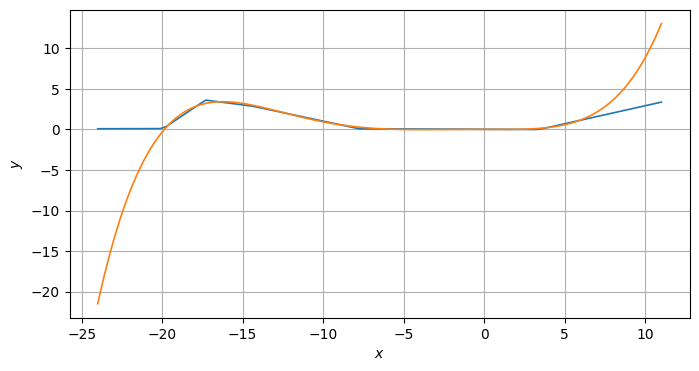

In [ ]:
#@title Visualise function approximation for out of distribution inputs
#Visualise function approximation for out of distribution inputs
x2_=torch.linspace(supp_x[0]-4,supp_x[1]+4,100)
y2_=model(torch.Tensor((x2_-mid_x)/(range_x/2)).unsqueeze(1).to(device)).squeeze().detach().cpu()
fig,ax=plt.subplots(figsize=(8,4),dpi=100)
plt.plot(x2_,mid_y+(range_y/2)*y2_,color='C0',linewidth=1.2)
plt.plot(x2_,target_fn(x2_),color='C1',linewidth=1.2)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Loss plots

As discussed, we split the full dataset into a set of training data, which was used to compute the loss used to update the parameters of the network at each iteration, and validation data, which we can use to detect overfitting. Expand and run the contained cells to visualise the loss on each subset throughout training.

It is expected that the loss on the training data will continue to reduce throughout training. While the loss on the validation data should be expected to reduce at first, it may begin to rise at some point during training. This rise is typically indicative of the network overfitting on the training data, and is therefore the basis for the detection of such a failure. However, it is possible that the validation data is not representative of the full distribution, in which case this detection can suffer from false positives or false negatives.

For overfitting to be possible, the network must be complex enough to approximate functions that are more complex than the target function, and the training data must provide a sparse representation of the underlying distribution. It is therefore likely that you will only see a rise in the validation loss here under these conditions.

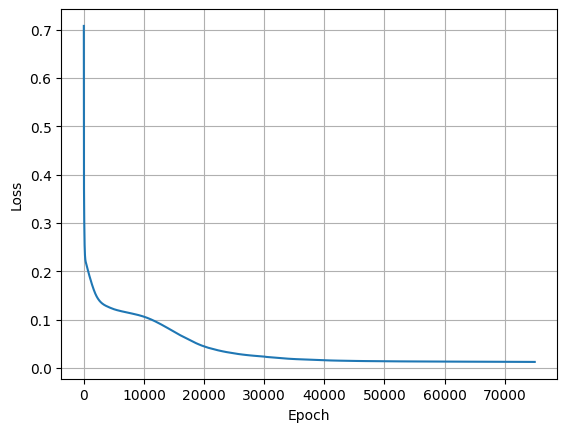

In [ ]:
#@title Visualise train loss
plt.plot(torch.linspace(0,len(train_plt)-1,len(train_plt)),np.array(train_plt))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

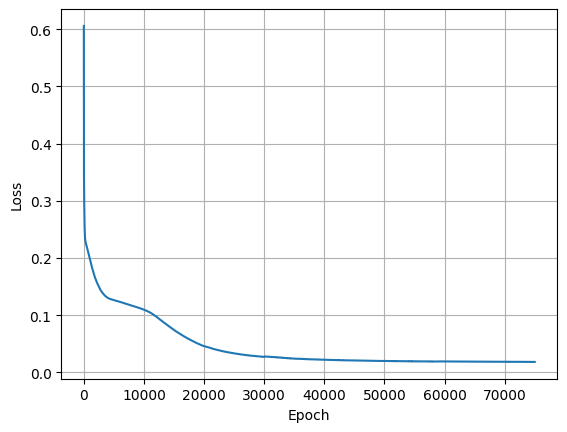

In [ ]:
#@title Visualise validation loss
plt.plot(torch.linspace(0,len(test_plt)-1,len(test_plt)),np.array(test_plt))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

# A note on the preservation of topology

Suppose you want to approximate a discontinuous target function (see below cell for example). What issues might you encounter?

Whatever you do, you will observe that the network is unable to create a "hole" as is needed to model a discontinuity. This is because neural networks "preserve topology", i.e. they can stretch/bend/warp/etc. the input space, but they cannot cut holes into it or stitch different pieces of it together (neighbourhoods of points are always preserved).

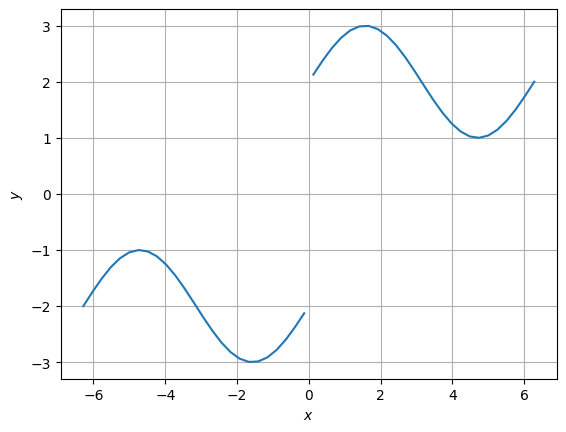

In [ ]:
#@title Visualise discontinuous function
x1_=np.linspace(-2*np.pi,2*np.pi)
y1_=np.sin(x1_)-2
y1_[len(y1_)//2:]+=4
plt.plot(x1_[:len(y1_)//2],y1_[:len(y1_)//2],color='C0')
plt.plot(x1_[len(y1_)//2:],y1_[len(y1_)//2:],color='C0')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.show()